# Train Model on TrueFoundry
This notebook demonstrates a demo on how you can train an image classification model on mnist dataset and deploy the model training job on truefoundry platform.

# 🛠 Setup
To follow along with the notebook, you will have to do the following:
* Install `truefoundry` and required ML Libraries
* Setup logging
* Select the Workspace in which you want to deploy your application.
* Install the required packages

In [ ]:
%pip install -U -q "truefoundry>=0.5.1" "tensorflow==2.15.0" "matplotlib==3.8.2"

### Login into TrueFoundry

In order to login run the cell below. Host can be found from the TrueFoundry UI as shown below like https://app.truefoundry.com

![image.png](../common/images/host.png)

In [ ]:
!tfy login --host "<Host name of TrueFoundry UI. e.g. https://company.truefoundry.cloud>"

### Create a ML Repo

We will be using the ML Repo to store the model artifacts and results of our model training. You can create an ML Repo using the following the docs at: https://docs.truefoundry.com/docs/key-concepts#creating-an-ml-repo

### Select the `Workspace` in which you want to deploy your application.

Once you run the cell below you will get a prompt to enter your workspace. Follow the docs to

a. Create a Workspace: https://docs.truefoundry.com/docs/key-concepts#creating-a-workspace  
b. Grant Editor access to ML Repo we created above: https://docs.truefoundry.com/docs/key-concepts#grant-access-of-ml-repo-to-workspace  


Or, just get the workspace FQN for existing workspace with access: https://docs.truefoundry.com/docs/key-concepts#getting-workspace-fqn


Once done, you should have a workspace FQN that you can paste in the next cell when prompted

In [ ]:
import click

In [ ]:
import click

WORKSPACE_FQN = click.prompt(
    "Enter the Workspace FQN",
    type=str,
)
ML_REPO = click.prompt(
    "Enter the name of ML Repo to use",
    type=str,
)

print(f"\nWorkspace FQN set to {WORKSPACE_FQN!r}")
print(f"\nML Repo set to {ML_REPO!r}")

# MNIST Dataset - Problem Statement and Data Exploration

The MNIST dataset is a popular benchmark dataset in the field of machine learning and computer vision. It consists of a large collection of handwritten digits (0-9) in grayscale images, along with their corresponding labels.

### Problem Statement

The problem associated with the MNIST dataset is to train a model that can accurately classify the given images of handwritten digits into their respective classes. It is a classification problem with 10 classes (0-9), where each image represents a single digit.

### Data Exploration

Let's explore the MNIST dataset by loading and visualizing some of its samples.

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize the pixel values between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

print(f"The number of train images: {len(x_train)}")
print(f"The number of test images: {len(x_test)}")

The MNIST dataset is divided into two sets: a training set (x_train and y_train) and a testing set (x_test and y_test). The training set contains 60,000 images, while the testing set contains 10,000 images.

Now, let's visualize some samples from the dataset using matplotlib:

In [ ]:
from truefoundry.ml import get_client

client = get_client()
run = client.create_run(ml_repo=ML_REPO, run_name="train-model")

# Plot some sample images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

run.log_plots({"images": plt})
plt.tight_layout()
plt.show()


The code above plots a grid of 10 sample images from the training set. Each image is displayed in grayscale, and the corresponding label is shown as the title.

You can see that the images are 28x28 pixels in size and represent handwritten digits. The labels indicate the true values of the digits.

# Train the model




### Defining the model

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


### Log Parameters

In [ ]:
#logging the parameters
run.log_params({"optimizer": "adam", "loss": "sparse_categorical_crossentropy", "metric": ["accuracy"]})

### Train the model

In [ ]:
# Train the model
epochs = 5
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

### Log Metrics and Model

In [ ]:
history_dict = history.history
train_accuracy = history_dict['accuracy']  # Training accuracy per epoch
val_accuracy = history_dict['val_accuracy'] 
loss_per_epoch = history_dict['loss']  # Training loss per epoch
#Logging the metrics of the model
for epoch in range(epochs):
    run.log_metrics({"train_accuracy": train_accuracy[epoch], "val_accuracy": val_accuracy[epoch], "loss": loss_per_epoch[epoch]}, step=epoch)

In [ ]:
#Here we are logging the metrics of the model
run.log_metrics(metric_dict={"accuracy": accuracy, "loss": loss})

# Save the trained model
model.save('mnist_model.h5')

#here we are logging the model
run.log_model(
    name="handwritten-digits-recognition",
    model_file_or_folder='mnist_model.h5',
    framework="tensorflow",
    description="sample model to recognize the handwritten digits",
    metadata={"accuracy": accuracy, "loss": loss}
)

### Making predictions with the model

In [ ]:
# Make predictions using the model
predictions = model.predict(x_test[:10])
predicted_labels = [tf.argmax(prediction).numpy() for prediction in predictions]
print(f'Predicted labels: {predicted_labels}')

### Deploy as a Training Job


In [17]:
!pygmentize train_job/deploy.py

import argparse
import logging

from truefoundry.deploy import Build, Job, LocalSource, Param, PythonBuild, Resources

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(name)s] %(levelname)-8s %(message)s"
)

# parsing the arguments
parser = argparse.ArgumentParser()
parser.add_argument("--workspace_fqn", type=str, required=True, help="fqn of the workspace to deploy to")
args = parser.parse_args()

# defining the job specifications
job = Job(
    name="mnist-train-job",
    image=Build(
        build_source=LocalSource(local_build=False),
        build_spec=PythonBuild(
            python_version="3.11",
            command="python train.py --num_epochs {{num_epochs}} --ml_repo {{ml_repo}}",
            requirements_path="requirements.txt",
        ),
    ),
    params=[
        Param(name="num_epochs", default="4"),
        Param(name="ml_repo", param_type="ml_repo"),
    ],
    resources=Resources(cpu_request=0.5, cpu_limit=0.5, memory_request=1500, memory_limit=200

In [ ]:
!cd train_job && python deploy.py --workspace_fqn $WORKSPACE_FQN

### Trigger Job Runs from the deployed job
You can trigger job run from:
1. TrueFoundry UI (Click on the Play button on your job on top right of the screen)
2. Python code (Run the cell below and enter the Application FQN. You can find it on the deployed job page as shown below)
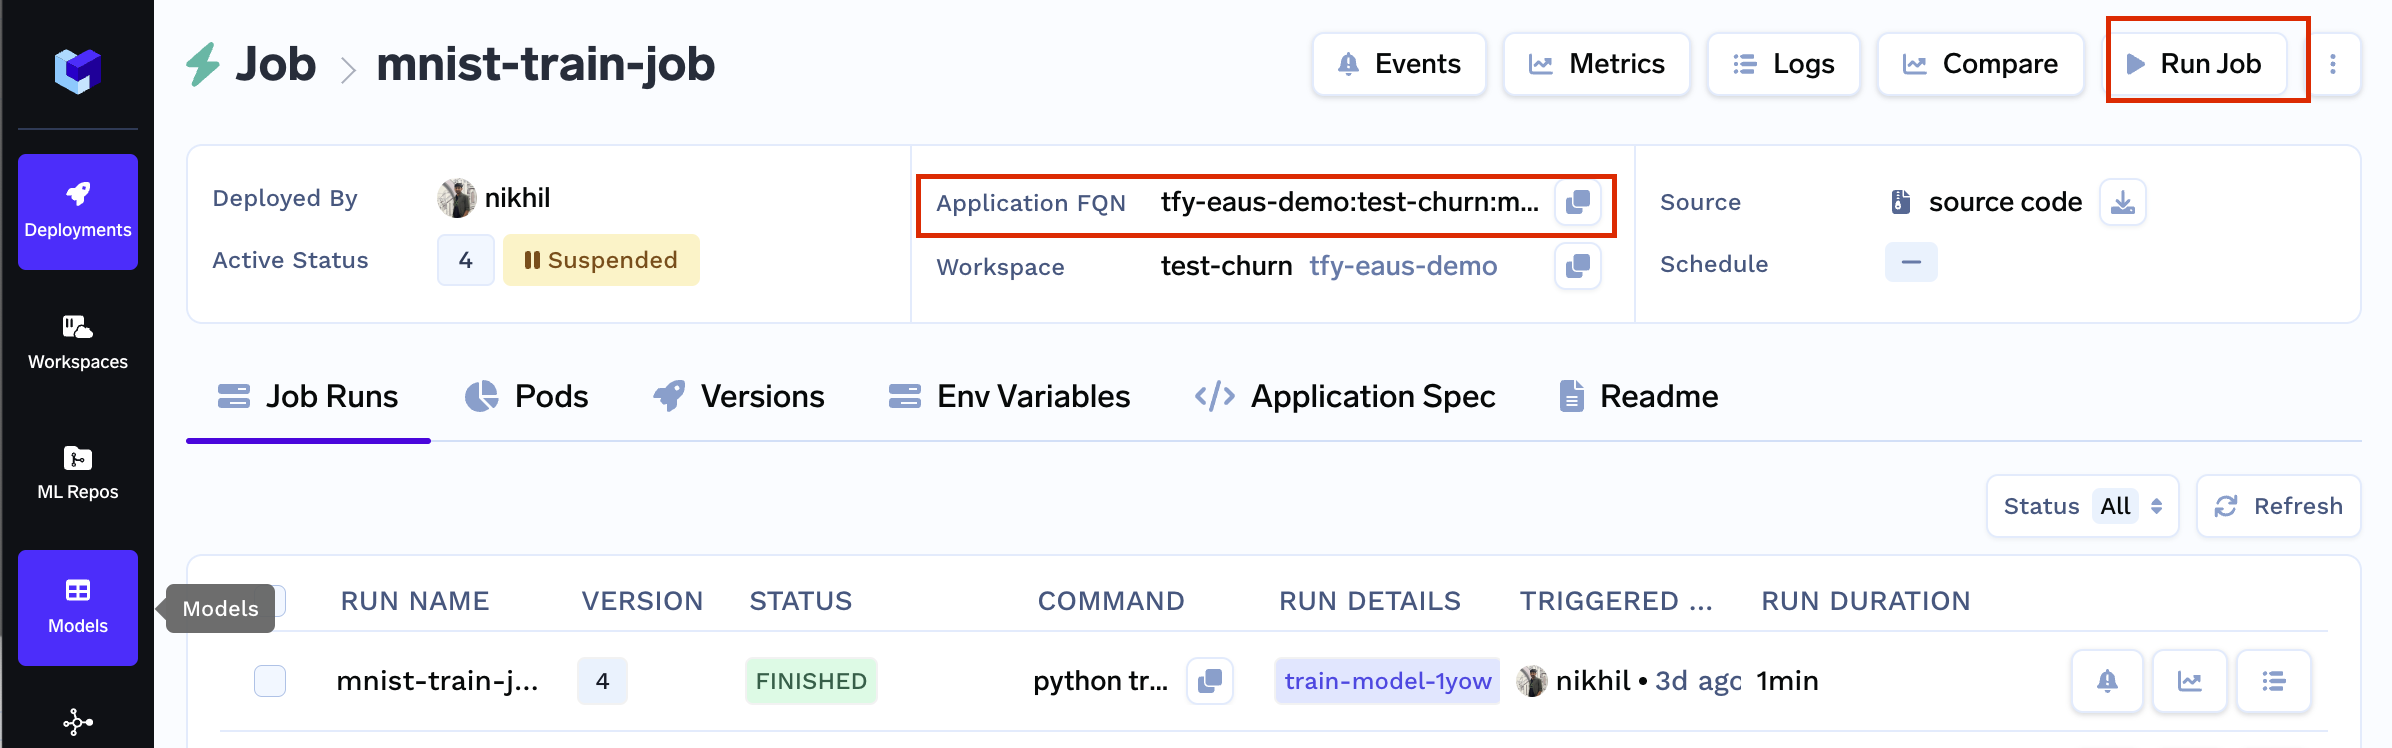

In [ ]:
APPLICATION_FQN = click.prompt(
    "Enter the Application FQN of your Job",
    type=str,
)
print(f"\nApplication FQN set to {APPLICATION_FQN!r}")

In [ ]:
from truefoundry.deploy import trigger_job

trigger_job(
    APPLICATION_FQN, 
    params={
        "num_epochs":"3",
        "ml_repo": ML_REPO,
    }
)

You can see the job run in the UI as shown below. The job run will have a run associated with it which will track all the metrics and artifacts created during the job run.

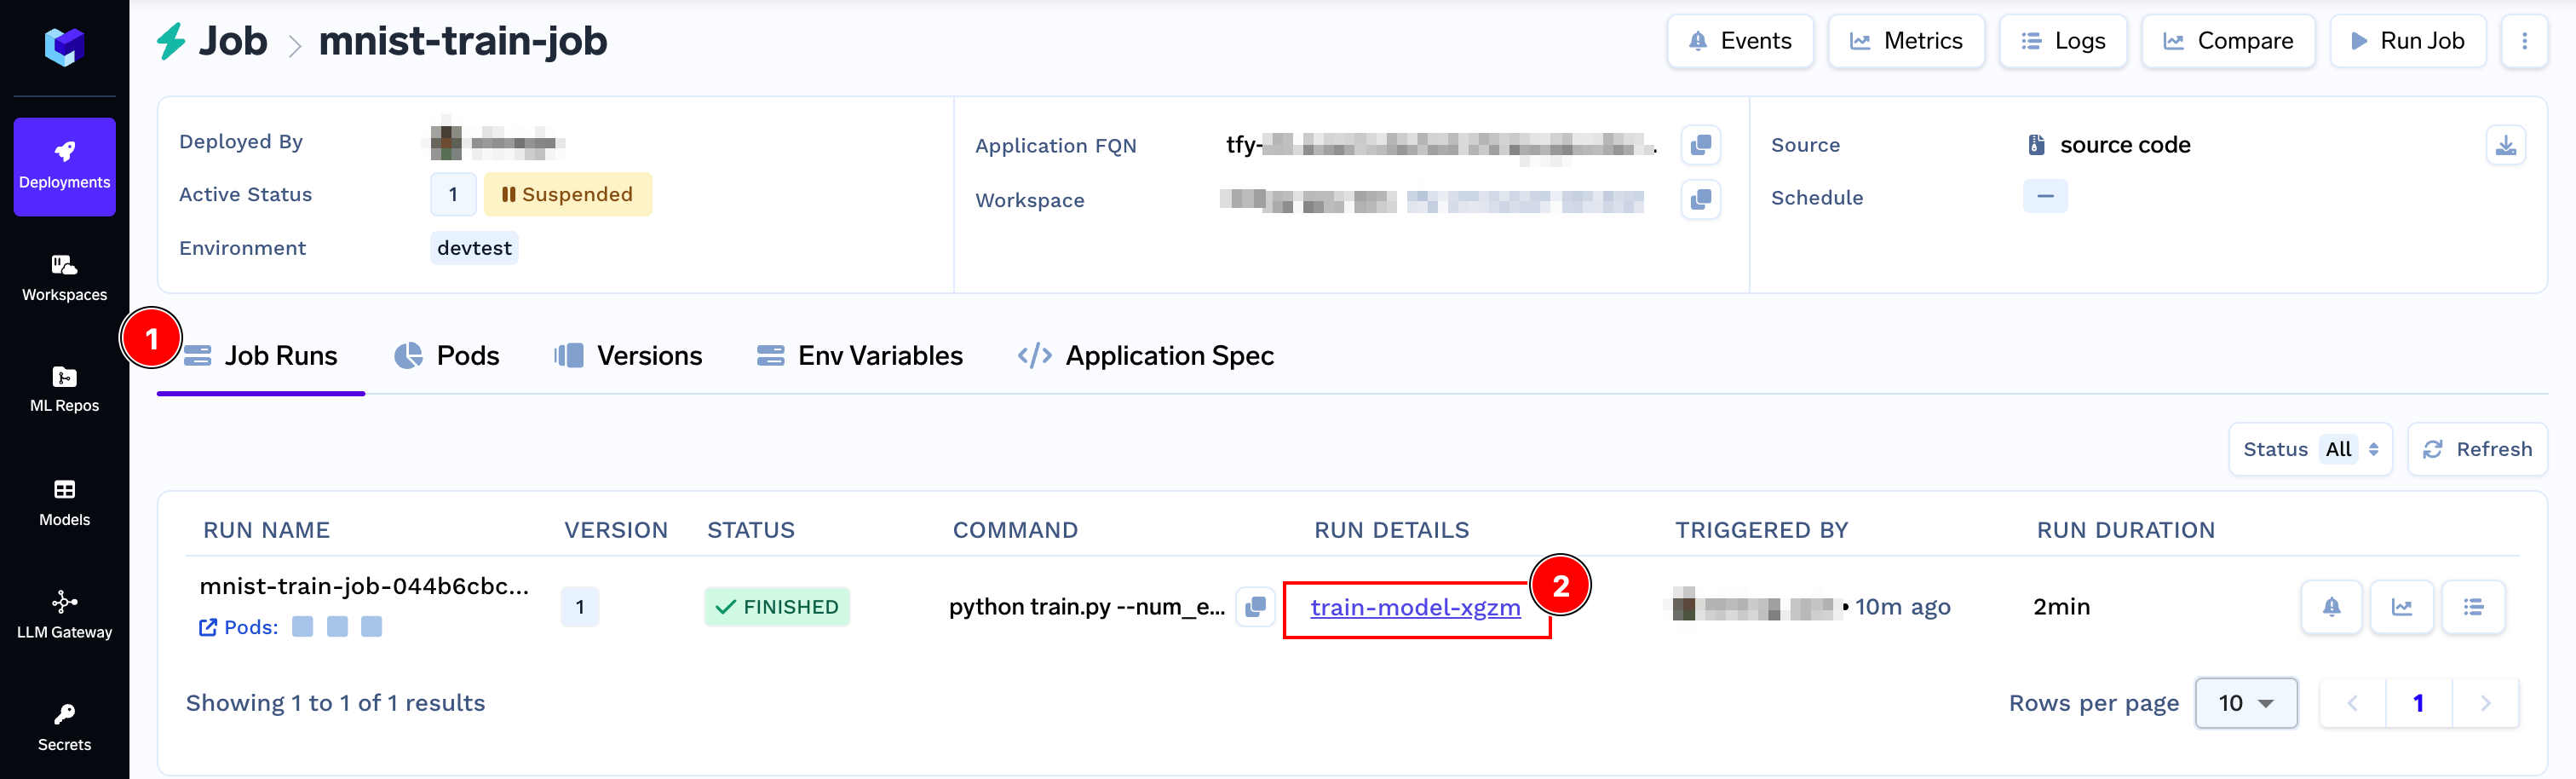
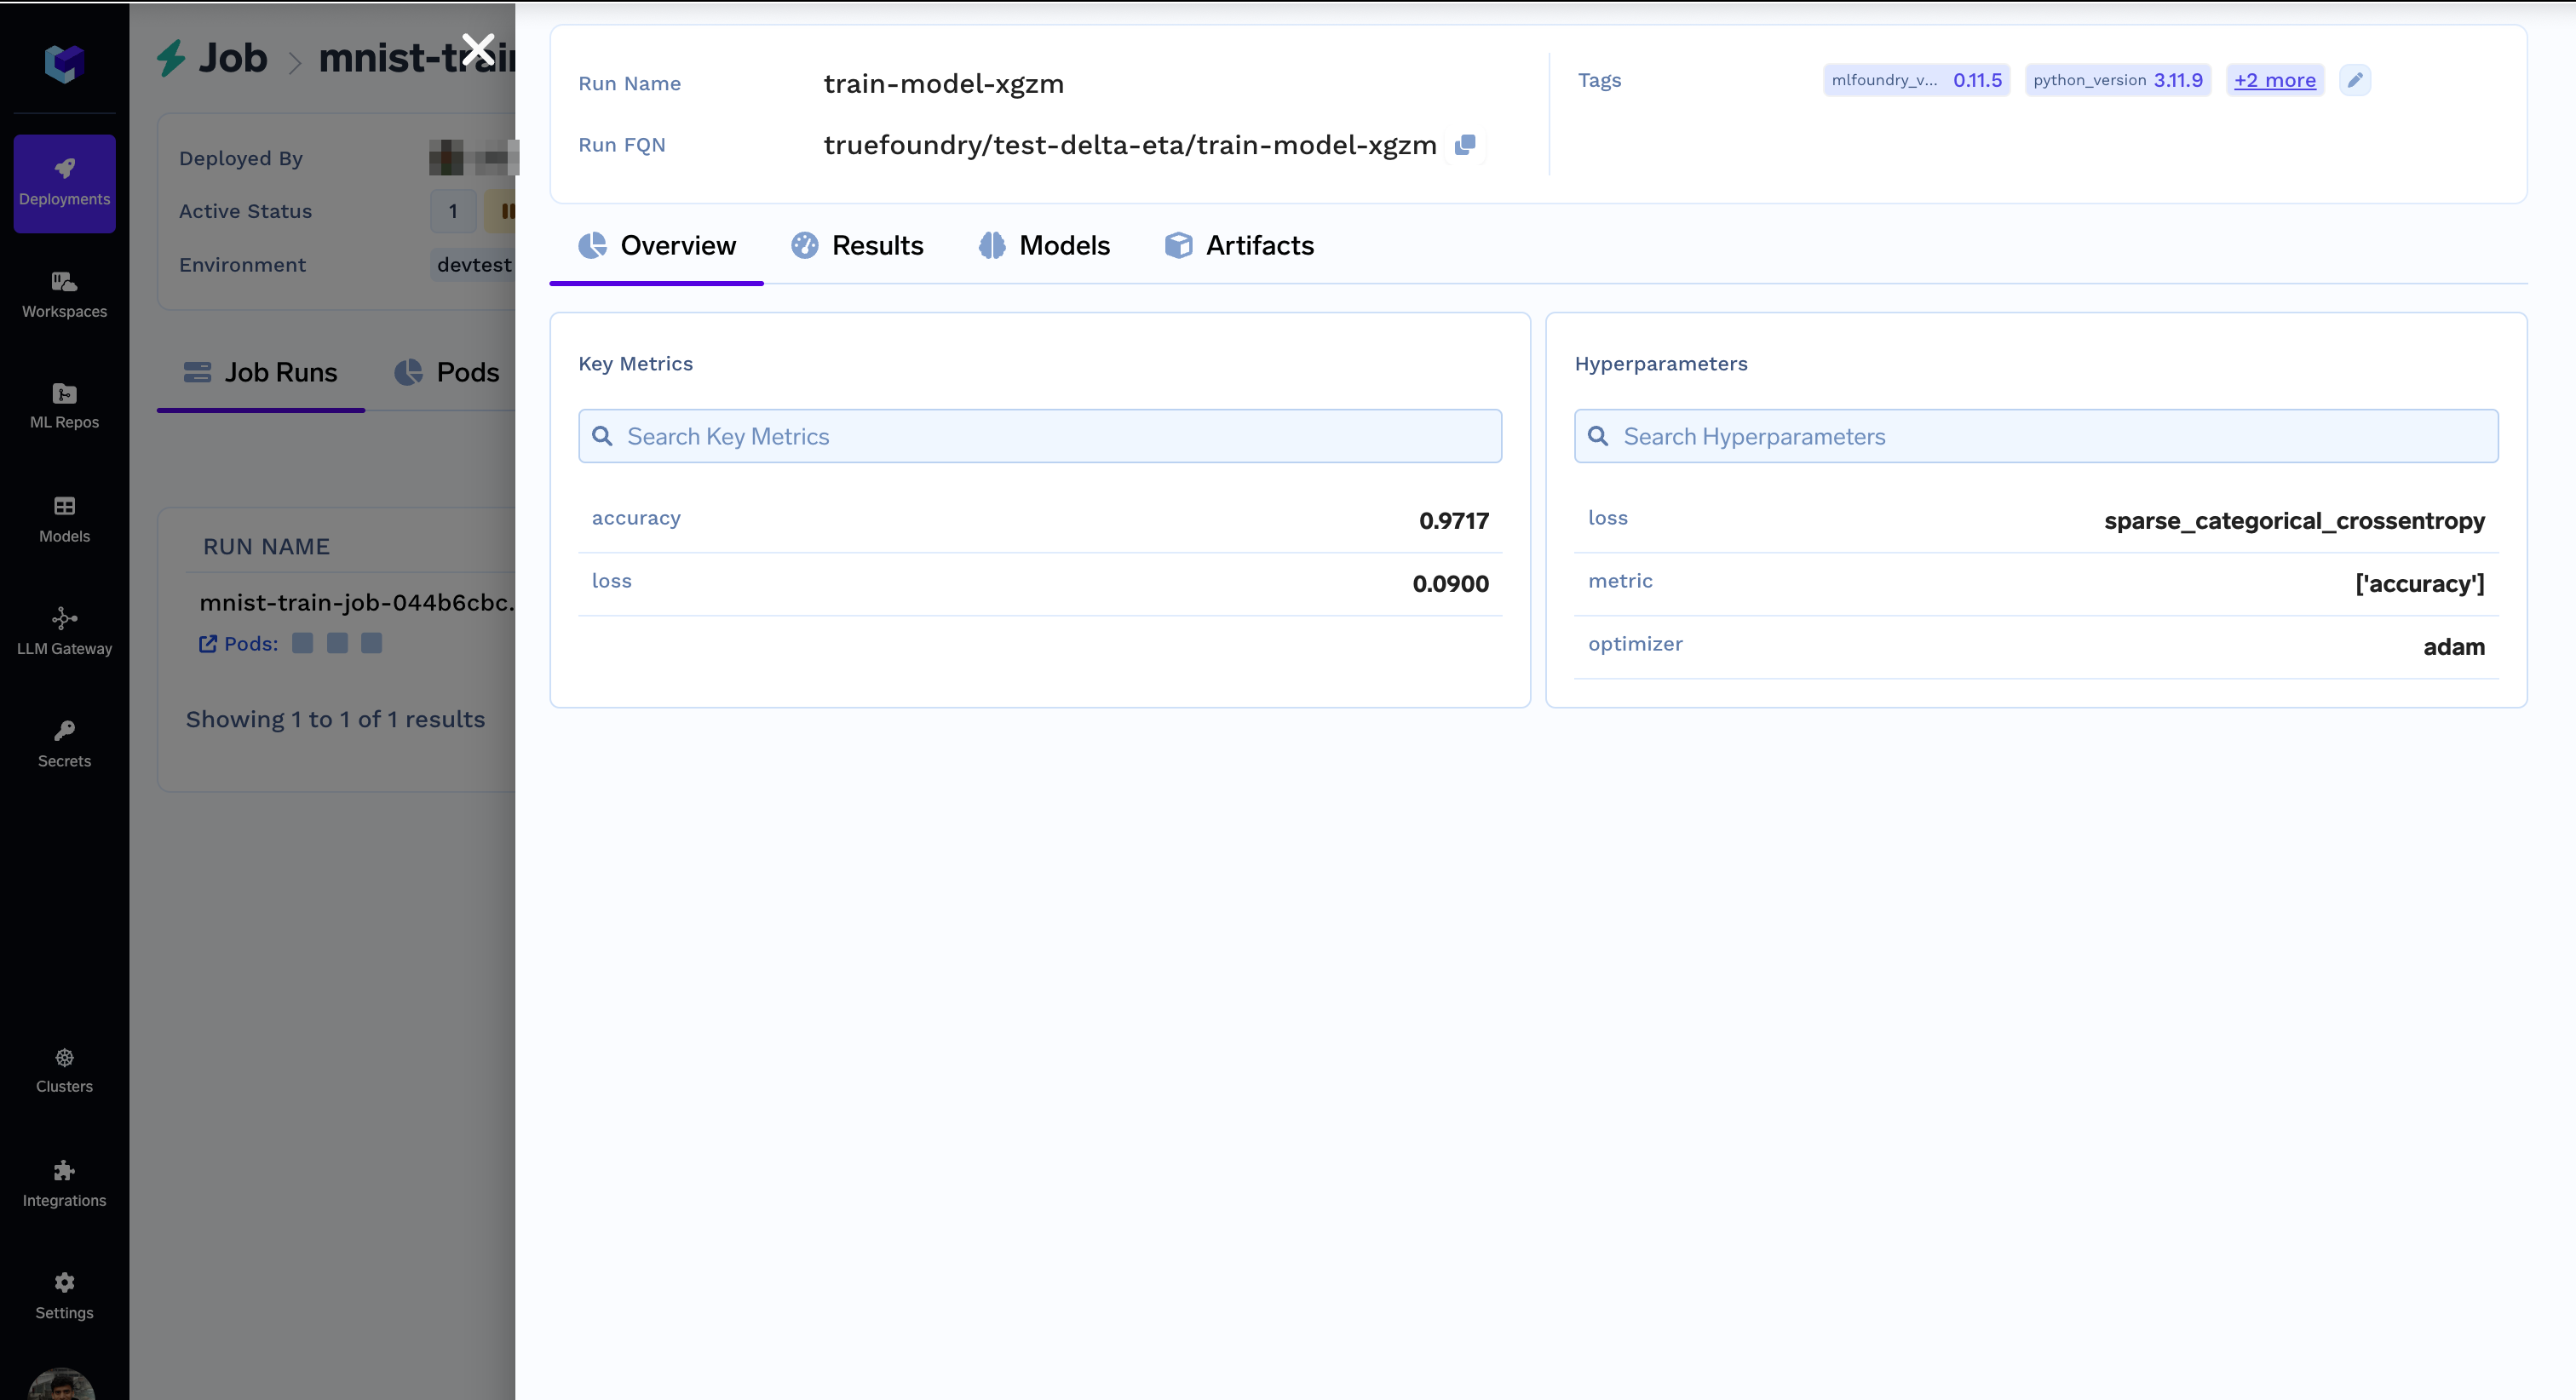